In [54]:
import pandas as pd
import numpy as np
import re
import datetime
from scipy.stats import chisquare
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
from nltk import classify
from nltk import NaiveBayesClassifier
import random

In [3]:
#read csv
BF=pd.read_csv("Battlefieldreviews.csv")

In [33]:
#look at data
BF.head(5)

,helpful,recommendations,hours,review,date,Help,funny,Month,Day,Year,HoursBinned
0,No one has rated this review as helpful yet0,Recommended,95.9,"Pretty good now, shame it took this long to ge...",27 January,0.0,0.0,January,27,2023.0,"(93.95, 7570.1]"
1,No one has rated this review as helpful yet0,Recommended,1.0,surprisingly good! Shields are OP :) one hit k...,27 January,0.0,0.0,January,27,2023.0,"(0.099, 12.4]"
2,No one has rated this review as helpful yet0,Recommended,5.5,"i got this game today, and played 5.5 hours st...",27 January,0.0,0.0,January,27,2023.0,"(0.099, 12.4]"
3,1 person found this review helpful0,Recommended,54.8,started out rough but the game has really turn...,27 January,1.0,0.0,January,27,2023.0,"(40.2, 93.95]"
4,1 person found this review helpful0,Recommended,35.6,Fun game,27 January,1.0,0.0,January,27,2023.0,"(12.4, 40.2]"


In [5]:
BF=BF.drop(["Unnamed: 0"],axis=1)

In [6]:
#remove \t from review column
BF['review']=BF.apply(lambda row: re.sub("\t","",str(row['review'])),axis =1)

In [7]:
#split X amount of people found this helpful and Y amount of people found this funny 
BF[["Help","funny"]]=BF["helpful"].str.split(n=1,expand= True)

In [8]:
#Remove all letters from Help
BF['Help']=BF.apply(lambda row: re.sub("[A-z]","",str(row['Help'])),axis =1)

In [9]:
#remove all letters from funny
BF['funny']=BF.apply(lambda row: re.sub("[A-z]","",str(row['funny'])),axis =1)

In [10]:
#remove all letters froms hours
BF['hours']=BF.apply(lambda row: re.sub("[A-z]","",str(row['hours'])),axis =1)

In [11]:
# remove spaces in hours
BF['hours']=BF.apply(lambda row: re.sub(" ","",str(row['hours'])),axis =1)

In [12]:
#remove ',' from hours
BF['hours']=BF.apply(lambda row: re.sub(",","",str(row['hours'])),axis =1)

In [13]:
#covert string to float
BF["hours"]=BF["hours"].astype("float")

In [14]:
#remove posted from date
BF["date"] = BF.apply(lambda row: re.sub("Posted: ","",str(row["date"])),axis =1)

In [15]:
#extract month from date and put it in its column
BF["Month"]=BF.apply(lambda row : re.search("[A-z]+", str(row["date"])).group(),axis =1)
BF["Month"].unique()

array(['January', 'December', 'November', 'October', 'September',
       'August', 'July', 'June', 'May', 'April', 'March', 'February'],
      dtype=object)

In [16]:
#extract day from date
BF["Day"]=BF.apply(lambda row : re.search("[0-9]+", str(row["date"])).group(),axis =1)
BF["Day"].unique()

array(['27', '26', '25', '24', '23', '22', '21', '20', '19', '18', '17',
       '16', '15', '14', '13', '12', '11', '10', '9', '8', '7', '6', '5',
       '4', '3', '2', '1', '31', '30', '29', '28'], dtype=object)

In [17]:
#extract year from date
BF["Year"]=BF.apply(lambda row : re.search("[0-9]*$", str(row["date"])).group(),axis =1)

In [18]:
#remove days from the years column
BF["Year"]=BF["Year"].str.replace("^..$|^.$","")

C:\Users\bobby\AppData\Local\Temp\ipykernel_26024\552455930.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  BF["Year"]=BF["Year"].str.replace("^..$|^.$","")


In [19]:
#convert year to numeric and fill the nas with 2023 year
BF["Year"]=pd.to_numeric(BF["Year"]).fillna(2023)

In [20]:
#change help from string to float
BF["Help"]=pd.to_numeric(BF["Help"].str.replace(",","")).fillna(0)

In [21]:
# remove all letters and special charactors and convert string into numeric
BF["funny"]=BF["funny"].str.replace("<.*","")
BF["funny"]=BF["funny"].str.strip()
BF["funny"]=BF["funny"].str.replace("[A-z][0-9]","")
BF["funny"]=BF["funny"].str.replace(" [0-9]$","")
BF["funny"]=BF["funny"].str.replace(",","")
BF["funny"]=pd.to_numeric(BF["funny"])
BF["funny"]=BF.funny.fillna(0)

C:\Users\bobby\AppData\Local\Temp\ipykernel_26024\421992709.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  BF["funny"]=BF["funny"].str.replace("<.*","")
C:\Users\bobby\AppData\Local\Temp\ipykernel_26024\421992709.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  BF["funny"]=BF["funny"].str.replace("[A-z][0-9]","")
C:\Users\bobby\AppData\Local\Temp\ipykernel_26024\421992709.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  BF["funny"]=BF["funny"].str.replace(" [0-9]$","")


In [22]:
#looking at data
BF.describe()

,hours,Help,funny,Year
count,53547.000000,53547.000000,53547.000000,53547.000000
mean,79.308611,5.103180,1.985751,2021.614376
std,136.645217,104.535163,65.154383,0.532025
min,0.100000,0.000000,0.000000,2021.000000
25%,12.400000,0.000000,0.000000,2021.000000
50%,40.200000,1.000000,0.000000,2022.000000
75%,93.950000,2.000000,0.000000,2022.000000
max,7570.100000,12385.000000,8990.000000,2023.000000


array([[<AxesSubplot:title={'center':'hours'}>,
        <AxesSubplot:title={'center':'Help'}>],
       [<AxesSubplot:title={'center':'funny'}>, <AxesSubplot:>]],
      dtype=object)

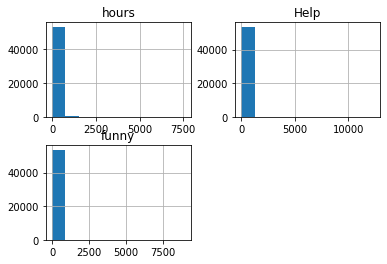

In [23]:
BF[["hours","Help","funny"]].hist()

<AxesSubplot:>

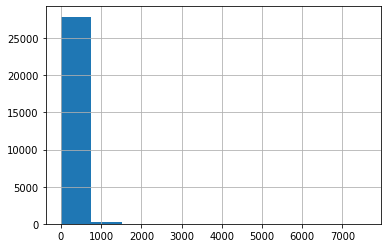

In [24]:
#Majority of players that recommended the game are between 0 to 600 hours played
BF.loc[BF["recommendations"]== 'Recommended']["hours"].hist()

<AxesSubplot:>

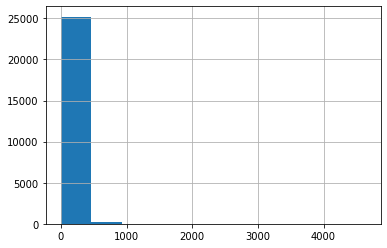

In [25]:
#Majority of players that do not recommended the game are between 0 to 600 hours played
BF.loc[BF["recommendations"]== 'Not Recommended']["hours"].hist()

In [26]:
#HoursBinned
BF["HoursBinned"]=pd.qcut(BF["hours"],q=4)
BF["HoursBinned"]

0        (93.95, 7570.1]
1          (0.099, 12.4]
2          (0.099, 12.4]
3          (40.2, 93.95]
4           (12.4, 40.2]
              ...       
53542      (0.099, 12.4]
53543      (0.099, 12.4]
53544      (0.099, 12.4]
53545      (0.099, 12.4]
53546       (12.4, 40.2]
Name: HoursBinned, Length: 53547, dtype: category
Categories (4, interval[float64, right]): [(0.099, 12.4] < (12.4, 40.2] < (40.2, 93.95] < (93.95, 7570.1]]

In [27]:
#Hoursbinned and recommendations 
c=BF.groupby(["HoursBinned","recommendations"]).count().reset_index()
c

,HoursBinned,recommendations,helpful,hours,review,date,Help,funny,Month,Day,Year
0,"(0.099, 12.4]",Not Recommended,10137,10137,10137,10137,10137,10137,10137,10137,10137
1,"(0.099, 12.4]",Recommended,3257,3257,3257,3257,3257,3257,3257,3257,3257
2,"(12.4, 40.2]",Not Recommended,6285,6285,6285,6285,6285,6285,6285,6285,6285
3,"(12.4, 40.2]",Recommended,7111,7111,7111,7111,7111,7111,7111,7111,7111
4,"(40.2, 93.95]",Not Recommended,4998,4998,4998,4998,4998,4998,4998,4998,4998
5,"(40.2, 93.95]",Recommended,8372,8372,8372,8372,8372,8372,8372,8372,8372
6,"(93.95, 7570.1]",Not Recommended,4030,4030,4030,4030,4030,4030,4030,4030,4030
7,"(93.95, 7570.1]",Recommended,9357,9357,9357,9357,9357,9357,9357,9357,9357


In [28]:
#calculate chisquare test for hours played and recommendate, the more hours somone has 
#the more likely they would recommend this game
NumberofNonRecommended=c[c["recommendations"]== "Not Recommended"]["helpful"].to_numpy()
NumberofRecommended=c[c["recommendations"]== "Recommended"]["helpful"].to_numpy()

d=np.array([NumberofNonRecommended,NumberofRecommended]).T
chisquare(d)

Power_divergenceResult(statistic=array([3387.8621611 , 3054.82446525]), pvalue=array([0., 0.]))

<AxesSubplot:xlabel='hours', ylabel='Help'>

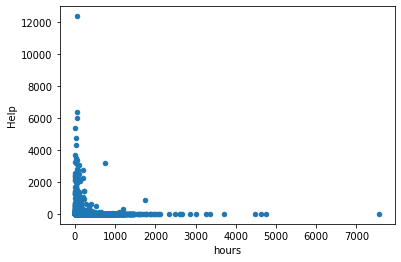

In [29]:
#there is no correlation between hours played and if the review was helpful for some people
BF.plot.scatter(x = "hours",
               y="Help")

<AxesSubplot:xlabel='hours', ylabel='funny'>

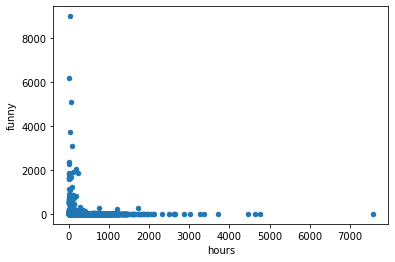

In [30]:
#there is no correlation between hours played and if the review was funny for some people
BF.plot.scatter(x = "hours",
               y="funny")

<AxesSubplot:xlabel='funny', ylabel='Help'>

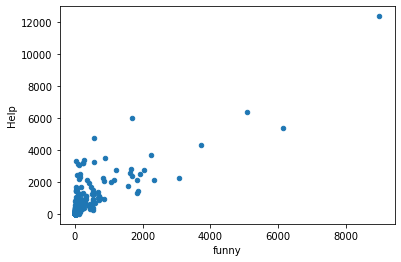

In [31]:
#seems to be correlation between Helpful and funny
BF.plot.scatter(x = "funny",
               y="Help")

In [37]:
#Put positive reviews in one variable
postive = BF[BF["recommendations"] == "Recommended"]
pos_list = postive["review"].tolist()

#Put negative reviews in another variable
neg = BF[BF["recommendations"] == "Not Recommended"]
neg_list = neg["review"].tolist()

In [38]:
#lower the words in both variables
pos_list_lowered = [word.lower() for word in pos_list] 
neg_list_lowered = [word.lower() for word in neg_list]

In [68]:
# add all the tuples together with a space inbetween
pos_list_to_string = ' '.join([str(elem) for elem in pos_list_lowered])  
neg_list_to_string = ' '.join([str(elem) for elem in neg_list_lowered])

In [74]:
mylist = ["get","game","play","still"]

In [95]:
#create stop words
stop = set(stopwords.words('english') + list(string.punctuation) + mylist)

In [96]:
# words will be separated based on whitespace
tokenizer = WhitespaceTokenizer()

In [97]:
#remove stops words from list
filtered_pos_list = [w for w in tokenizer.tokenize(pos_list_to_string) if w not in stop] 

filtered_neg_list = [w for w in tokenizer.tokenize(neg_list_to_string) if w not in stop]

In [98]:
#remove punctuation
filtered_pos_list2 = [w.strip(string.punctuation) for w in filtered_pos_list]
filtered_neg_list2 = [w.strip(string.punctuation) for w in filtered_neg_list]

In [99]:
#check the frequency of words
fd_pos = nltk.FreqDist(filtered_pos_list2) 
fd_neg = nltk.FreqDist(filtered_neg_list2)

In [100]:
fd_pos

FreqDist({'fun': 7807, 'good': 5278, 'battlefield': 5044, 'like': 4305, 'game': 4227, 'bugs': 3109, 'better': 2923, 'great': 2292, 'really': 2210, 'bad': 2206, ...})

In [101]:
fd_neg

FreqDist({'battlefield': 5492, 'game': 4447, 'like': 3755, 'even': 3237, 'refund': 2786, 'bad': 2568, 'money': 2427, 'time': 2163, 'buy': 2060, 'ea': 1944, ...})